In [1]:
%run ../initialize.ipynb

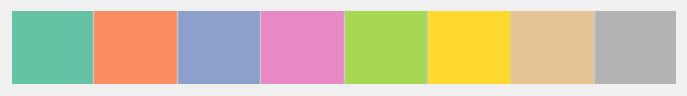

In [2]:
import sys
sys.path.append('../modeling-football-outcomes/config')
import mpl_style
colors = rcParams['axes.prop_cycle'].by_key()['color']

## Time features
* #### key: (game_id)
* #### table name: features.time_date
* #### __game_time_eastern__
* #### __game_time_local__
* #### __is_sunday__
* #### __day_of_week__
* #### __week_id__
* #### __is_playoffs__
* #### __is_superbowl__

In [3]:
key = 'game_id'
out_tbl = 'features.time_date'
features_list = []

In [ ]:
gametime = spark.table('game_metadata').join(
    spark.table('game'), on='game_id'
).join(
    spark.table('stadium'), on='stadium'
).select('game_id','time','stadium','timezone',
         'day_of_week','week_id').cache()

### time of day
* raw times are eastern
* can use timezone to adjust
* issue with timezones: daylight savings and Wembley
 * not going to worry about adjusting for this
 * since raw times are eastern, local time adjustment is (tz + 5)
 * e.g. SF is -8 --> -8 + 5 = -3, so a "1pm" game is 10am local

In [4]:
def mod_time(tm):
    '''given a time like 7:02pm, 
    round the hour and return a value
    0-23 where 0 is midnight and 14 is 2pm'''
    tm, ampm = (tm[:-2], tm[-2:])
    hr, mn = map(float, tm.split(':'))
    if mn >= 30:
        hr += 1
    if ampm == 'pm':
        hr += 12
    
    return hr
mod_time_udf = udf(mod_time, FloatType())

gametime = gametime.withColumn(
    'game_time_eastern', mod_time_udf('time')
).withColumn(
    'game_time_local', 
    ## Eastern Time is -5, so TZ+5 adjusts to local time
    col('timezone') + F.lit(5) + col('game_time_eastern')
)

features_list += ['game_time_eastern','game_time_local']

In [5]:
gametime.filter(col('stadium') == 'AT&T Stadium').limit(5).toPandas()

,game_id,time,stadium,timezone,day_of_week,week_id,game_time_eastern,game_time_local
0,201409070dal,4:25pm,AT&T Stadium,-6.0,6,1,16.0,15.0
1,201411020dal,1:04pm,AT&T Stadium,-6.0,6,9,13.0,12.0
2,201410190dal,4:25pm,AT&T Stadium,-6.0,6,7,16.0,15.0
3,201309080dal,8:30pm,AT&T Stadium,-6.0,6,1,21.0,20.0
4,201510110dal,4:25pm,AT&T Stadium,-6.0,6,5,16.0,15.0


#### day of week -- raw
 * very sparse other than Sunday. 
 * could encode as "is_sunday" feature
 * could leave as is
  * upside: since Sunday (6) is the max #, could allow tree to split how it sees fit
    * group (Mon, Thurs, Sat) vs. Sun... or (Mon) vs. (Thurs, Sat, Sun), etc.
  * downside: this might be overfitting
 * will go with both

In [6]:
gametime = gametime.withColumn(
    'day_of_week', col('day_of_week').cast(FloatType())
).withColumn(
    'is_sunday', F.when(col('day_of_week') == 6., 1.).otherwise(0.)
)

features_list += ['day_of_week','is_sunday']

In [7]:
gametime.groupby('is_sunday').count().toPandas()

,is_sunday,count
0,0.0,429
1,1.0,2508


#### is playoffs
#### week # -- raw

In [8]:
gametime.groupby('week_id').count().toPandas()

,week_id,count
0,19,44
1,7,155
2,6,155
3,9,147
4,17,176
5,5,154
6,1,175
7,10,156
8,3,176
9,12,173


In [9]:
gametime = gametime.withColumn(
    'week_id', col('week_id').cast(FloatType())
).withColumn(
    'is_playoffs', F.when(col('week_id') >= 18, 1.).otherwise(0.)
).withColumn(
    'is_superbowl', F.when(col('week_id') == 21, 1.).otherwise(0.)
)

features_list += ['week_id','is_playoffs','is_superbowl']

### Write table

In [10]:
    gametime.select(*([key] + features_list))\
            .write.mode('overwrite').saveAsTable(out_tbl)